## Predictive models for NFL games to enable spread betting.

### Load packages and data files

In [13]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score
from sklearn.preprocessing import StandardScaler
from scipy.stats.mstats import winsorize

In [14]:
# regression model packages
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor

## Model and basic feature evaluation

In [15]:
# Function to train the model
def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

scaler = StandardScaler()

In [16]:
def plot_heatmap(results, values='MSE'):
    """
    Creates and plots a heatmap of the mean values of a specified column 
    with Model as rows and Feature_Set as columns.

    Parameters:
    results (DataFrame): The input DataFrame containing the data.
    values (str): The name of the column to use for the values in the pivot table (default is 'MSE').

    Returns:
    None
    """
    # Create crosstab with Model as rows, Feature_Set as columns, and mean of the specified values
    crosstab_df = pd.pivot_table(results, values=values, index='Model', columns='Feature_Set', aggfunc='mean')

    # Plot heatmap with gradient color scale (red to yellow to green)
    plt.figure(figsize=(8, 6))
    sns.heatmap(crosstab_df, cmap='RdYlGn_r', annot=True, fmt=".1f", linewidths=0.5, cbar_kws={'label': values}, annot_kws={"size": 8})

    # Add title to the heatmap
    plt.title(f'Average {values} by Model and Feature_Set')

    # Display the heatmap
    plt.show()


In [17]:
#import data
merged_df = pd.read_csv('../data/nfl_games_pfr_features.csv')
print(merged_df.columns)

#Separate played and upcoming games
merged_played = merged_df[~merged_df['Margin Yds'].isna()]
merged_upcoming = merged_df[merged_df['Margin Yds'].isna()]

Index(['Unnamed: 0', 'Day', 'Date', 'Time', 'Winner', 'LoserIsHome', 'Loser',
       'PtsW', 'PtsL', 'YdsW', 'TOW', 'YdsL', 'TOL', 'season', 'week',
       'Winner Abbr', 'Loser Abbr', 'Home Team', 'Away Team', 'Home Score',
       'Away Score', 'Winner Yds', 'Loser Yds', 'Margin Yds', 'Winner TO',
       'Loser TO', 'Margin TO', 'Margin Pts', 'Total Pts', 'Margin Pct',
       'home_team_winner', 'away_win_bonus', 'DateTime',
       'DaysSinceLastGame_Home', 'DaysSinceLastGame_Away', 'Home_DefenseRank',
       'Home_OffenseRank', 'Home_ScoreRank', 'Week', 'Away_DefenseRank',
       'Away_OffenseRank', 'Away_ScoreRank', 'Spread', 'Delta_OffenseRank',
       'Ratio_OffenseRank', 'Delta_DefenseRank', 'Ratio_DefenseRank',
       'Delta_ScoreRank', 'Ratio_ScoreRank', 'intTerm1', 'intTerm2',
       'intTerm3', 'intTerm4', 'quadTerm1', 'quadTerm2', 'quadTerm3',
       'quadTerm4', 'HomeStrength', 'AwayStrength', 'Home_Impact',
       'Away_Impact', 'Impact', 'ImpactNeg', 'Differential_Home',


C:\Users\see_w\AppData\Roaming\Python\Python313\site-packages\scipy\stats\_continuous_distns.py:801: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))


  Distribution                                         Parameters  \
2      lognorm  (0.1024964586094354, -88.93469540772521, 133.8...   
3        gamma  (44.962887687651445, -47.05934877450369, 2.062...   
4         beta  (44.968448119074154, 768285.378027474, -47.067...   
7            t  (24.19408272625686, 45.512162070263514, 13.256...   
5  weibull_min  (2.7270174476648004, 10.843348303687064, 39.22...   
0         norm           (45.669815371404034, 13.840766042601562)   
6  weibull_max  (95653551.2328388, 1596567118.616407, 15965670...   
8      uniform                                       (3.0, 102.0)   
1        expon                          (3.0, 42.669815371404034)   

   KS Statistic        P-Value  
2      0.028262   4.752831e-02  
3      0.029119   3.776513e-02  
4      0.029125   3.771096e-02  
7      0.037425   2.858428e-03  
5      0.039111   1.564717e-03  
0      0.044798   1.686295e-04  
6      0.126717   4.650600e-33  
8      0.312294  2.629684e-202  
1      0.358

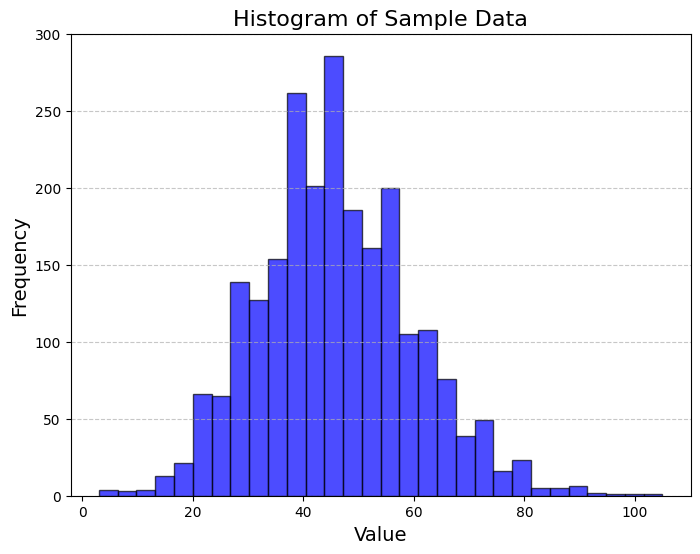

In [18]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

def determine_best_distribution(data):
    """
    Determines the best distribution for a given dataset.
    
    Parameters:
        data (array-like): The dataset to analyze.
    
    Returns:
        pd.DataFrame: DataFrame containing distribution names, parameters, KS statistic, and p-value.
    """
    # List of distributions to check
    distributions = [
        stats.norm, stats.expon, stats.lognorm, stats.gamma, stats.beta,
        stats.weibull_min, stats.weibull_max, stats.t, stats.uniform
    ]
    
    results = []
    for dist in distributions:
        try:
            # Fit the distribution to data
            params = dist.fit(data)
            
            # Perform the KS test
            ks_stat, p_value = stats.kstest(data, dist.name, args=params)
            
            # Store the results
            results.append({
                'Distribution': dist.name,
                'Parameters': params,
                'KS Statistic': ks_stat,
                'P-Value': p_value
            })
        except Exception as e:
            # Catch exceptions for distributions that fail
            results.append({
                'Distribution': dist.name,
                'Parameters': None,
                'KS Statistic': np.nan,
                'P-Value': np.nan,
                'Error': str(e)
            })
    
    # Convert results to a DataFrame and sort by KS Statistic (lower is better)
    results_df = pd.DataFrame(results).sort_values(by='KS Statistic')
    return results_df

# Example usage
filtered_played = merged_played[merged_played['Delta_ScoreRank'].abs() >= 0.000]
sample_data = filtered_played['Total Pts']
    
# Determine the best distribution
best_dist = determine_best_distribution(sample_data)
print(best_dist)

# Create the histogram
plt.figure(figsize=(8, 6))
plt.hist(sample_data, bins=30, alpha=0.7, color='blue', edgecolor='black')

# Add labels and title
plt.title('Histogram of Sample Data', fontsize=16)
plt.xlabel('Value', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Display the plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [19]:
# Define features and target

filtered_played = merged_played[(merged_played['Delta_ScoreRank'].abs() >= 0.000) & (merged_played['week'] < 17)]

feature_sets = [
    ('1A.1', filtered_played[['Home_ScoreRank', 'Away_ScoreRank']]), 
    ('1B.1', filtered_played[['Delta_ScoreRank']]),
    ('1C.1', filtered_played[['Ratio_ScoreRank']]),
    ('2A.1', filtered_played[['Home_OffenseRank', 'Home_DefenseRank', 'Home_ScoreRank', 'Away_OffenseRank', 'Away_DefenseRank', 'Away_ScoreRank']]),
    ('2B.1', filtered_played[['Delta_ScoreRank', 'Delta_OffenseRank', 'Delta_DefenseRank']]),
    ('2C.1', filtered_played[['Ratio_ScoreRank', 'Ratio_OffenseRank', 'Ratio_DefenseRank']]),
    ('4A.1', filtered_played[['Home_OffenseRank', 'Home_DefenseRank', 'Home_ScoreRank', 'Away_OffenseRank', 'Away_DefenseRank', 'Away_ScoreRank',  
                              'intTerm1', 'intTerm2', 'intTerm3', 'intTerm4', 'quadTerm1', 'quadTerm2', 'quadTerm3', 'quadTerm4', 
                              'DaysSinceLastGame_Home', 'DaysSinceLastGame_Away', 'HomeStrength', 'AwayStrength','Home_Impact','Away_Impact', 'Impact',
                              'Differential_Home', 'Differential_Away', 'Differential']]),
    ('4B.1', filtered_played[['Delta_ScoreRank', 'Delta_OffenseRank', 'Delta_DefenseRank',  
                              'intTerm1', 'intTerm2', 'intTerm3', 'intTerm4', 'quadTerm1', 'quadTerm2', 'quadTerm3', 'quadTerm4', 
                              'DaysSinceLastGame_Home', 'DaysSinceLastGame_Away', 'HomeStrength', 'AwayStrength','Home_Impact','Away_Impact', 'Impact',
                              'Differential_Home', 'Differential_Away', 'Differential']]),
    ('4C.1', filtered_played[['Ratio_ScoreRank', 'Ratio_OffenseRank', 'Ratio_DefenseRank', 
                              'intTerm1', 'intTerm2', 'intTerm3', 'intTerm4', 'quadTerm1', 'quadTerm2', 'quadTerm3', 'quadTerm4', 
                              'DaysSinceLastGame_Home', 'DaysSinceLastGame_Away', 'HomeStrength', 'AwayStrength','Home_Impact','Away_Impact', 'Impact',
                              'Differential_Home', 'Differential_Away', 'Differential']]),
    ('5A.1', filtered_played[['Delta_ScoreRank', 'Delta_OffenseRank', 'Delta_DefenseRank',  
                              'intTerm1', 'intTerm2']]),
    ('5B.1', filtered_played[['Delta_ScoreRank', 'Delta_OffenseRank', 'Delta_DefenseRank',  
                              'Impact']]),
    ('5C.1', filtered_played[['Delta_ScoreRank', 'Delta_OffenseRank', 'Delta_DefenseRank', 
                              'Differential']]),
    ('5D.1', filtered_played[['Delta_ScoreRank', 'Delta_OffenseRank', 'Delta_DefenseRank', 
                              'intTerm1', 'intTerm2', 'Impact',
                              'Differential']]),
    ('5E.1', filtered_played[['Delta_ScoreRank', 'Delta_OffenseRank', 'Delta_DefenseRank', 
                              'Impact','Differential']]),
    ('5F.1', filtered_played[['Delta_ScoreRank', 'Impact','Differential']]),
    ('5G.1', filtered_played[['Ratio_ScoreRank','Impact','Differential']]),
    ]

#y = np.log(filtered_played['Total Pts'])
y = filtered_played['Spread']

# Define models
models = [
    ('LM', LinearRegression()),
    ('LMnoINT', LinearRegression(fit_intercept=False)),
    ('Ridge0.01', Ridge(alpha=0.01)),
    ('Ridge0.1', Ridge(alpha=0.1)),
    ('Ridge1.0', Ridge(alpha=1.0)),  # You can tune the alpha parameter
    ('XGBoostBase', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)),
    ('XGBoost150', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=150, learning_rate=0.1, max_depth=3, random_state=42)),
    ('XGBoost5', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50, learning_rate=0.1, max_depth=5, random_state=42)),
    ('XGBoost0.5', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50, learning_rate=0.05, max_depth=3, random_state=42)),
    ('RF50', RandomForestRegressor(n_estimators=50, max_depth=3, random_state=42)),
    ('RF10', RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)),
    ('SVM', SVR(kernel='rbf', C=1.0, epsilon=0.1)),
    ('SVMlin', SVR(kernel='linear', C=1.0, epsilon=0.1)),
    ('kNN10', KNeighborsRegressor(n_neighbors=10)),
    ('kNN20', KNeighborsRegressor(n_neighbors=20)),
    ('BaselineAvg', DummyRegressor(strategy='mean'))
]

for feature_name, feature_data in feature_sets:
    num_rows = feature_data.shape[0]  # Get the number of rows
    print(f"Feature Set {feature_name}: {num_rows} rows")

print("DONE")

Feature Set 1A.1: 2170 rows
Feature Set 1B.1: 2170 rows
Feature Set 1C.1: 2170 rows
Feature Set 2A.1: 2170 rows
Feature Set 2B.1: 2170 rows
Feature Set 2C.1: 2170 rows
Feature Set 4A.1: 2170 rows
Feature Set 4B.1: 2170 rows
Feature Set 4C.1: 2170 rows
Feature Set 5A.1: 2170 rows
Feature Set 5B.1: 2170 rows
Feature Set 5C.1: 2170 rows
Feature Set 5D.1: 2170 rows
Feature Set 5E.1: 2170 rows
Feature Set 5F.1: 2170 rows
Feature Set 5G.1: 2170 rows
DONE


In [20]:
# Evaluate models with cross-validation
# DataFrame to store results
results = pd.DataFrame(columns=['Model', 'Feature_Set', 'Fold', 'MSE', 'Accuracy'])

# Define cross-validation strategy (5 folds in this case)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Iterate over feature sets and models
for i, (feature_name, X) in enumerate(feature_sets):
    for model_name, model in models:
        print(f"Evaluating model: {model_name} with feature set {feature_name}")
        
        fold_number = 1
        # Cross-validation loop
        for train_index, test_index in kf.split(X):
            # Use iloc to select rows by integer index
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            # Train the model
            model = train_model(model, X_train, y_train)

            # Make predictions on the test set
            y_pred = model.predict(X_test)

            # Evaluate the model
            mse = mean_squared_error(y_test, y_pred)
            
            # Calculate accuracy of predicting the winner
            y_pred_winner = ['Home' if pred > 0 else 'Away' for pred in y_pred]
            y_test_winner = ['Home' if actual > 0 else 'Away' for actual in y_test]
            accuracy = accuracy_score(y_test_winner, y_pred_winner)
            
            # Store the results for each fold
            new_result = pd.DataFrame({
                'Model': [model_name],
                'Feature_Set': [feature_name],
                'Fold': [fold_number],
                'MSE': [mse],
                'Accuracy': [accuracy * 100]
            })
            results = pd.concat([results, new_result], ignore_index=True)
            
            fold_number += 1

# Print the results DataFrame
#print(results)

Evaluating model: LM with feature set 1A.1
Evaluating model: LMnoINT with feature set 1A.1
Evaluating model: Ridge0.01 with feature set 1A.1
Evaluating model: Ridge0.1 with feature set 1A.1
Evaluating model: Ridge1.0 with feature set 1A.1
Evaluating model: XGBoostBase with feature set 1A.1
Evaluating model: XGBoost150 with feature set 1A.1


C:\Users\see_w\AppData\Local\Temp\ipykernel_19640\3050472584.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_result], ignore_index=True)


Evaluating model: XGBoost5 with feature set 1A.1
Evaluating model: XGBoost0.5 with feature set 1A.1
Evaluating model: RF50 with feature set 1A.1
Evaluating model: RF10 with feature set 1A.1
Evaluating model: SVM with feature set 1A.1
Evaluating model: SVMlin with feature set 1A.1
Evaluating model: kNN10 with feature set 1A.1
Evaluating model: kNN20 with feature set 1A.1
Evaluating model: BaselineAvg with feature set 1A.1
Evaluating model: LM with feature set 1B.1
Evaluating model: LMnoINT with feature set 1B.1
Evaluating model: Ridge0.01 with feature set 1B.1
Evaluating model: Ridge0.1 with feature set 1B.1
Evaluating model: Ridge1.0 with feature set 1B.1
Evaluating model: XGBoostBase with feature set 1B.1
Evaluating model: XGBoost150 with feature set 1B.1
Evaluating model: XGBoost5 with feature set 1B.1
Evaluating model: XGBoost0.5 with feature set 1B.1
Evaluating model: RF50 with feature set 1B.1
Evaluating model: RF10 with feature set 1B.1
Evaluating model: SVM with feature set 1B.1

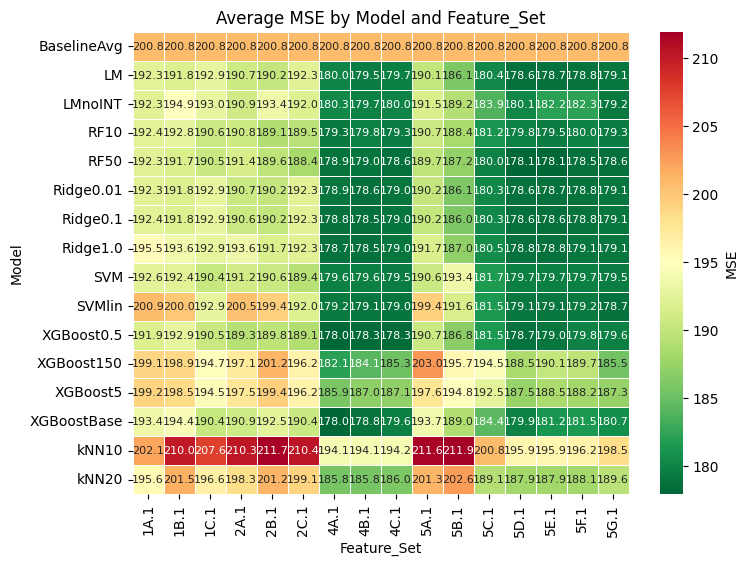

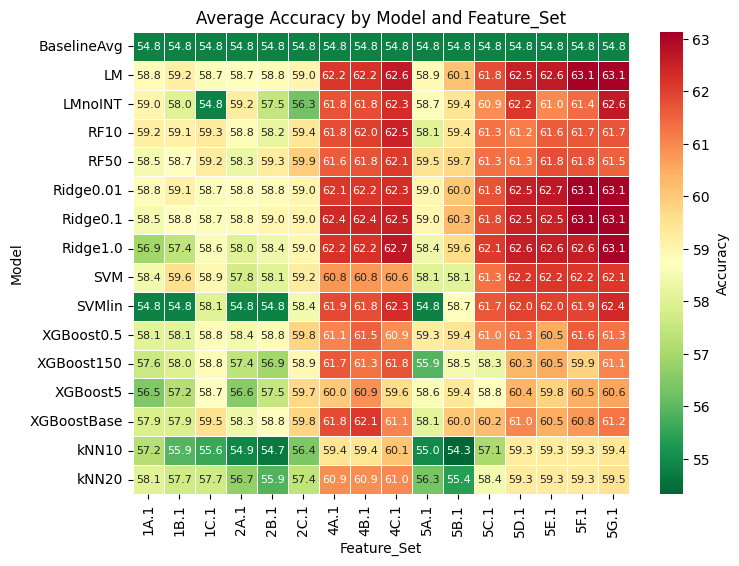

In [21]:
plot_heatmap(results, values='MSE')
plot_heatmap(results, values='Accuracy')

In [25]:
feature_sets = [
    ('4C.1', filtered_played[['Ratio_ScoreRank', 'Ratio_OffenseRank', 'Ratio_DefenseRank', 
                              'intTerm1', 'intTerm2', 'intTerm3', 'intTerm4', 'quadTerm1', 'quadTerm2', 'quadTerm3', 'quadTerm4', 
                              'DaysSinceLastGame_Home', 'DaysSinceLastGame_Away', 'HomeStrength', 'AwayStrength','Home_Impact','Away_Impact', 'Impact',
                              'Differential_Home', 'Differential_Away', 'Differential']]),
    ('5F.1', filtered_played[['Ratio_ScoreRank', 'Impact','Differential']]),
    ]

#y = np.log(filtered_played['Total Pts'])
y = filtered_played['Spread']

# Define models
models = [
    ('LM', LinearRegression()),
    ('Ridge1.0', Ridge(alpha=1.0)),
    ('XGBoost0.5', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50, learning_rate=0.05, max_depth=3, random_state=42)),
    ('RF10', RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)),
    ('SVMlin', SVR(kernel='linear', C=1.0, epsilon=0.1)),
    ('kNN20', KNeighborsRegressor(n_neighbors=20)),
    ('BaselineAvg',Ridge(alpha=1.0))
]

In [26]:
from itertools import combinations

# Evaluate ensemble models with cross-validation
# DataFrame to store ensemble results
ensemble_results = pd.DataFrame(columns=['Model', 'Feature_Set', 'Fold', 'MSE', 'Accuracy'])

# Define cross-validation strategy (5 folds in this case)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Get the first 5 models (excluding baseline)
ensemble_models = models[:-1]  # Exclude BaselineAvg
baseline_model = models[-1]    # BaselineAvg

# Generate all combinations of 2, 3, 4, 5, and 6 models
model_combinations = []
for r in [2, 3, 4, 5, 6]:
    for combo in combinations(range(len(ensemble_models)), r):
        model_names = [ensemble_models[i][0] for i in combo]
        model_objects = [ensemble_models[i][1] for i in combo]
        ensemble_name = f"Ensemble_{'+'.join(model_names)}"
        model_combinations.append((ensemble_name, model_objects, combo))

print(f"Evaluating {len(model_combinations)} ensemble combinations:")
for ensemble_name, _, _ in model_combinations:
    print(f"  - {ensemble_name}")

# Iterate over feature sets and ensemble combinations
for feature_name, X in feature_sets:
    print(f"\nEvaluating feature set: {feature_name}")
    
    # Evaluate each ensemble combination
    for ensemble_name, model_objects, model_indices in model_combinations:
        print(f"  Evaluating ensemble: {ensemble_name}")
        
        fold_number = 1
        # Cross-validation loop
        for train_index, test_index in kf.split(X):
            # Use iloc to select rows by integer index
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            # Train each model in the ensemble
            trained_models = []
            for i, model_idx in enumerate(model_indices):
                # Create a fresh instance of the model
                model_name, model_class = ensemble_models[model_idx]
                if hasattr(model_class, 'get_params'):
                    # For sklearn models, create new instance with same parameters
                    model_instance = model_class.__class__(**model_class.get_params())
                else:
                    # Fallback for other models
                    model_instance = model_class
                
                trained_model = train_model(model_instance, X_train, y_train)
                trained_models.append(trained_model)
            
            # Make ensemble predictions (simple averaging)
            ensemble_predictions = np.zeros(len(X_test))
            for trained_model in trained_models:
                ensemble_predictions += trained_model.predict(X_test)
            ensemble_predictions /= len(trained_models)  # Average the predictions
            
            # Evaluate the ensemble
            mse = mean_squared_error(y_test, ensemble_predictions)
            
            # Calculate accuracy of predicting the winner
            y_pred_winner = ['Home' if pred > 0 else 'Away' for pred in ensemble_predictions]
            y_test_winner = ['Home' if actual > 0 else 'Away' for actual in y_test]
            accuracy = accuracy_score(y_test_winner, y_pred_winner)
            
            # Store the results for each fold
            new_result = pd.DataFrame({
                'Model': [ensemble_name],
                'Feature_Set': [feature_name],
                'Fold': [fold_number],
                'MSE': [mse],
                'Accuracy': [accuracy * 100]
            })
            ensemble_results = pd.concat([ensemble_results, new_result], ignore_index=True)
            
            fold_number += 1
    
    # Also evaluate baseline for comparison
    print(f"  Evaluating baseline: {baseline_model[0]}")
    fold_number = 1
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Train baseline model
        baseline_instance = baseline_model[1].__class__(**baseline_model[1].get_params())
        trained_baseline = train_model(baseline_instance, X_train, y_train)
        
        # Make predictions
        y_pred = trained_baseline.predict(X_test)
        
        # Evaluate the baseline
        mse = mean_squared_error(y_test, y_pred)
        
        # Calculate accuracy of predicting the winner
        y_pred_winner = ['Home' if pred > 0 else 'Away' for pred in y_pred]
        y_test_winner = ['Home' if actual > 0 else 'Away' for actual in y_test]
        accuracy = accuracy_score(y_test_winner, y_pred_winner)
        
        # Store the results for each fold
        new_result = pd.DataFrame({
            'Model': [baseline_model[0]],
            'Feature_Set': [feature_name],
            'Fold': [fold_number],
            'MSE': [mse],
            'Accuracy': [accuracy * 100]
        })
        ensemble_results = pd.concat([ensemble_results, new_result], ignore_index=True)
        
        fold_number += 1

print("\nEnsemble evaluation complete!")
print(f"Total ensemble combinations evaluated: {len(model_combinations)}")
print(f"Total results rows: {len(ensemble_results)}")

Evaluating 57 ensemble combinations:
  - Ensemble_LM+Ridge1.0
  - Ensemble_LM+XGBoost0.5
  - Ensemble_LM+RF10
  - Ensemble_LM+SVMlin
  - Ensemble_LM+kNN20
  - Ensemble_Ridge1.0+XGBoost0.5
  - Ensemble_Ridge1.0+RF10
  - Ensemble_Ridge1.0+SVMlin
  - Ensemble_Ridge1.0+kNN20
  - Ensemble_XGBoost0.5+RF10
  - Ensemble_XGBoost0.5+SVMlin
  - Ensemble_XGBoost0.5+kNN20
  - Ensemble_RF10+SVMlin
  - Ensemble_RF10+kNN20
  - Ensemble_SVMlin+kNN20
  - Ensemble_LM+Ridge1.0+XGBoost0.5
  - Ensemble_LM+Ridge1.0+RF10
  - Ensemble_LM+Ridge1.0+SVMlin
  - Ensemble_LM+Ridge1.0+kNN20
  - Ensemble_LM+XGBoost0.5+RF10
  - Ensemble_LM+XGBoost0.5+SVMlin
  - Ensemble_LM+XGBoost0.5+kNN20
  - Ensemble_LM+RF10+SVMlin
  - Ensemble_LM+RF10+kNN20
  - Ensemble_LM+SVMlin+kNN20
  - Ensemble_Ridge1.0+XGBoost0.5+RF10
  - Ensemble_Ridge1.0+XGBoost0.5+SVMlin
  - Ensemble_Ridge1.0+XGBoost0.5+kNN20
  - Ensemble_Ridge1.0+RF10+SVMlin
  - Ensemble_Ridge1.0+RF10+kNN20
  - Ensemble_Ridge1.0+SVMlin+kNN20
  - Ensemble_XGBoost0.5+RF10+SVM

C:\Users\see_w\AppData\Local\Temp\ipykernel_19640\3657591895.py:79: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ensemble_results = pd.concat([ensemble_results, new_result], ignore_index=True)


  Evaluating ensemble: Ensemble_LM+SVMlin
  Evaluating ensemble: Ensemble_LM+kNN20
  Evaluating ensemble: Ensemble_Ridge1.0+XGBoost0.5
  Evaluating ensemble: Ensemble_Ridge1.0+RF10
  Evaluating ensemble: Ensemble_Ridge1.0+SVMlin
  Evaluating ensemble: Ensemble_Ridge1.0+kNN20
  Evaluating ensemble: Ensemble_XGBoost0.5+RF10
  Evaluating ensemble: Ensemble_XGBoost0.5+SVMlin
  Evaluating ensemble: Ensemble_XGBoost0.5+kNN20
  Evaluating ensemble: Ensemble_RF10+SVMlin
  Evaluating ensemble: Ensemble_RF10+kNN20
  Evaluating ensemble: Ensemble_SVMlin+kNN20
  Evaluating ensemble: Ensemble_LM+Ridge1.0+XGBoost0.5
  Evaluating ensemble: Ensemble_LM+Ridge1.0+RF10
  Evaluating ensemble: Ensemble_LM+Ridge1.0+SVMlin
  Evaluating ensemble: Ensemble_LM+Ridge1.0+kNN20
  Evaluating ensemble: Ensemble_LM+XGBoost0.5+RF10
  Evaluating ensemble: Ensemble_LM+XGBoost0.5+SVMlin
  Evaluating ensemble: Ensemble_LM+XGBoost0.5+kNN20
  Evaluating ensemble: Ensemble_LM+RF10+SVMlin
  Evaluating ensemble: Ensemble_LM+RF

TOP 10 MODELS BY LOWEST MSE:
Rank Model                               Feature_Set MSE      Accuracy
--------------------------------------------------------------------------------
1    Ensemble_Ridge1.0+XGBoost0.5        4C.1     177.33   61.61   %
2    Ensemble_XGBoost0.5+SVMlin          4C.1     177.36   61.66   %
3    Ensemble_Ridge1.0+XGBoost0.5+RF10   4C.1     177.36   62.03   %
4    Ensemble_Ridge1.0+XGBoost0.5+RF10+SVMlin 4C.1     177.37   61.94   %
5    Ensemble_XGBoost0.5+RF10+SVMlin     4C.1     177.39   61.75   %
6    Ensemble_LM+XGBoost0.5+RF10+SVMlin  4C.1     177.40   61.75   %
7    Ensemble_LM+Ridge1.0+XGBoost0.5+RF10 4C.1     177.43   61.89   %
8    Ensemble_LM+XGBoost0.5+RF10         4C.1     177.49   61.80   %

TOP 10 MODELS BY HIGHEST ACCURACY:
Rank Model                               Feature_Set MSE      Accuracy
--------------------------------------------------------------------------------
1    Ensemble_LM+Ridge1.0+SVMlin+kNN20   4C.1     178.63   63.18   %
2   

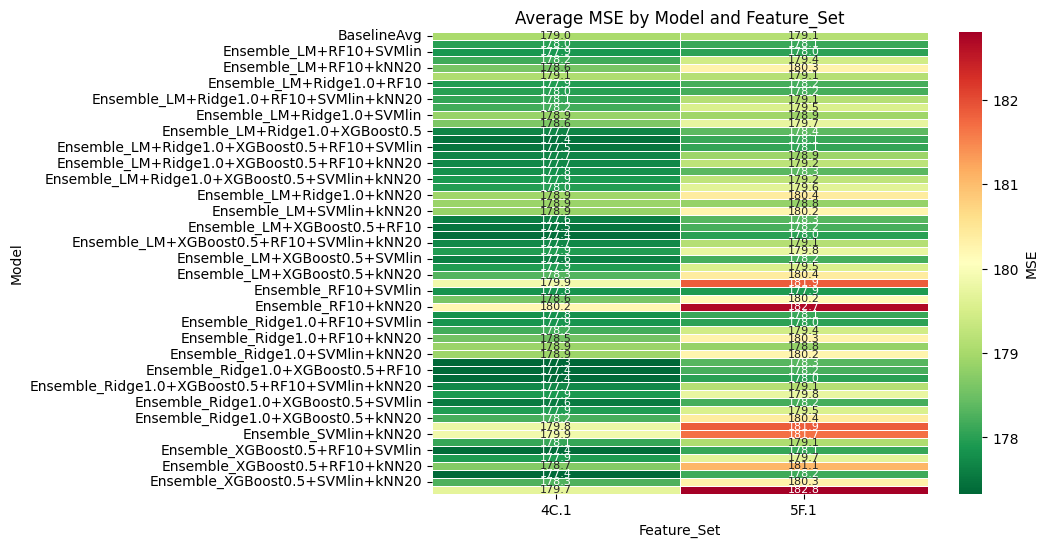

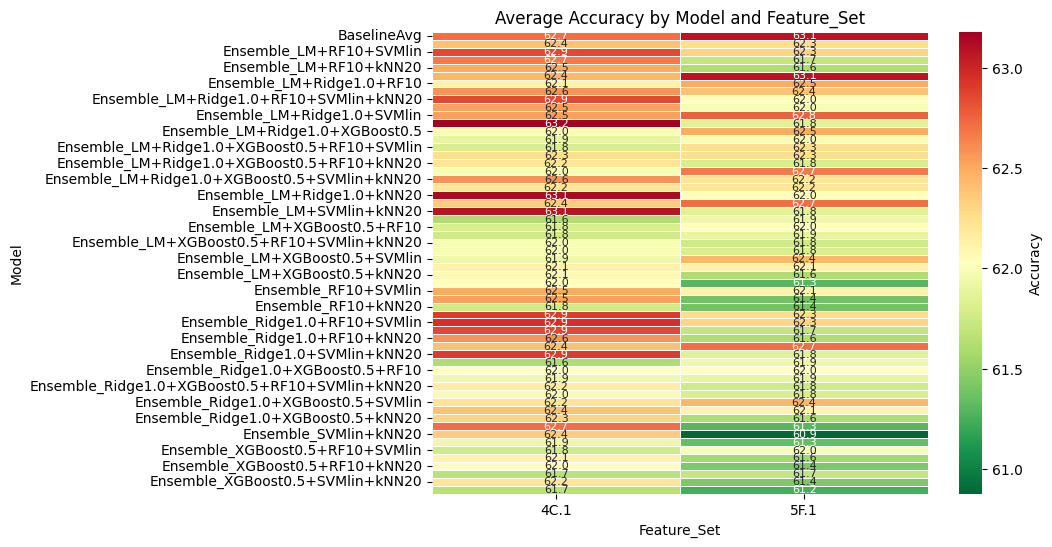

In [27]:
# Create summary table with both MSE and Accuracy for each model
summary_stats = ensemble_results.groupby(['Model', 'Feature_Set']).agg({
    'MSE': 'mean',
    'Accuracy': 'mean'
}).reset_index()

print("TOP 10 MODELS BY LOWEST MSE:")
print("=" * 80)
top_mse = summary_stats.sort_values('MSE').head(8)
print(f"{'Rank':<4} {'Model':<35} {'Feature_Set':<8} {'MSE':<8} {'Accuracy':<8}")
print("-" * 80)
for i, (_, row) in enumerate(top_mse.iterrows(), 1):
    print(f"{i:<4} {row['Model']:<35} {row['Feature_Set']:<8} {row['MSE']:<8.2f} {row['Accuracy']:<8.2f}%")

print(f"\nTOP 10 MODELS BY HIGHEST ACCURACY:")
print("=" * 80)
top_accuracy = summary_stats.sort_values('Accuracy', ascending=False).head(8)
print(f"{'Rank':<4} {'Model':<35} {'Feature_Set':<8} {'MSE':<8} {'Accuracy':<8}")
print("-" * 80)
for i, (_, row) in enumerate(top_accuracy.iterrows(), 1):
    print(f"{i:<4} {row['Model']:<35} {row['Feature_Set']:<8} {row['MSE']:<8.2f} {row['Accuracy']:<8.2f}%")

print("\n" + "=" * 80)

plot_heatmap(ensemble_results, values='MSE')
plot_heatmap(ensemble_results, values='Accuracy')

## Optimize the best model and feature set

Models: Random Forest, SVM, XGBoost  
